In [1]:
%matplotlib inline

# Planar Pendulum Example

This example shows how to solve the planar pendulum in full coordinate space. This results in a dae system with one algebraic equation.

The problem is easily stated: a pendulum must move on a circle with radius l,
it has a mass m, and gravitational accelleration is g.

The Lagragian is $L = 1/2 m (u^2 + v^2) - m g y$, with constraint: $x^2+y^2 = l$. $u$ is the speed $\dot x$ and $v$ is $\dot y$.

Adding a Lagrange multiplier $\lambda$, we arrive at the Euler Lagrange
differential equations for the problem:
$$
\begin{array}{ll}
\dot{x} = u \\
\dot{y} = v \\
\dot{u} = \lambda \frac x m\\
\dot{v} = \lambda \frac y m - g\\
\end{array}
$$
and $\lambda$ must be such that the constraint is satisfied:
$x^2+y^2 = l$.

We next derive a different constraint that contains more of the unknowns, as well as $\lambda$.
Derivation to time of the constraint gives a new constraint:
$x u + y v =0$.

Derivating a second time to time gives us:
$$u^2 + v^2 + x \dot{u} + y \dot{v} = 0$$
which can be written with the known form of $\dot{u}$, $\dot{v}$ as
$$u^2 + v^2 + \lambda \frac{l^2}{m} - g y = 0.$$

This last expression will be used to find the solution to the planar pendulum problem.

The algorithm first needs to find initial conditions for the derivatives,
then it solves the problme at hand. We take $g=1$, $m=1$, $l=1$.

In [2]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np
from scikits.odes import dae

In [3]:
#data of the pendulum
l = 1.0
m = 1.0
g = 1.0
#initial condition
theta0= np.pi/3 #starting angle
x0=np.sin(theta0)
y0=-(l-x0**2)**.5
lambdaval = 0.1
z0  = [x0, y0, 0., 0., lambdaval]
zp0 = [0., 0., lambdaval*x0/m, lambdaval*y0/m-g, -g]

We need a first order system cast into residual equations, so we convert the problem as such. This consists of 4 differential equations and one algebraic equation: 
$$
\begin{array}{ll}
0 = u - \dot{x}\\
0 = v - \dot{y}\\
0 = -\dot{u} + \lambda \frac x m\\
0 = -\dot{v} + \lambda \frac y m - g\\
0 = u^2 + v^2 + \lambda \frac{l^2}{m} - g y
\end{array}
$$
You need to define a function that computes the right hand side of above equation:

In [4]:
def residual(t, x, xdot, result):
    """ we create the residual equations for the problem"""
    result[0] = x[2]-xdot[0]
    result[1] = x[3]-xdot[1]
    result[2] = -xdot[2]+x[4]*x[0]/m
    result[3] = -xdot[3]+x[4]*x[1]/m-g
    result[4] = x[2]**2 + x[3]**2 \
                    + (x[0]**2 + x[1]**2)/m*x[4] - x[1] * g

To solve the DAE you define a dae object, specify the solver to use, here ida, and pass the residual function. You request the solution at specific timepoints by passing an array of times to the solve member.

In [5]:
solver = dae('ida', residual, 
             compute_initcond='yp0',
             first_step_size=1e-18,
             atol=1e-6,
             rtol=1e-6,
             algebraic_vars_idx=[4],
             compute_initcond_t0 = 60,
             old_api=False)
solution = solver.solve([0., 1., 2.], z0, zp0)

In [6]:
print('\n   t        Solution')
print('----------------------')
for t, u in zip(solution.values.t, solution.values.y):
    print('{0:>4.0f} {1:15.6g} '.format(t, u[0]))



   t        Solution
----------------------
   0        0.866025 
   1        0.592663 
   2       -0.304225 


You can continue the solver by passing further times. Calling the solve routine reinits the solver, so you can restart at whatever time. To continue from the last computed solution, pass the last obtained time and solution. 

**Note:** The solver performes better if it can take into account history information, so avoid calling solve to continue computation!

In general, you must check for errors using the errors output of solve.

In [7]:
#Solve over the next hour by continuation
times = np.linspace(0, 3600, 61)
times[0] = solution.values.t[-1]
solution = solver.solve(times, solution.values.y[-1], solution.values.ydot[-1])
if solution.errors.t:
    print ('Error: ', solution.message, 'Error at time', solution.errors.t)
print ('Computed Solutions:')
print('\n   t        Solution ')
print('-----------------------')
for t, u in zip(solution.values.t, solution.values.y):
    print('{0:>4.0f} {1:15.6g}'.format(t, u[0]))


Error:  Could not reach endpoint Error at time 15.7411967287
Computed Solutions:

   t        Solution 
-----------------------
   2       -0.304225


The solution fails at a time around 15 seconds. Errors can be due to many things. Here however the reason is simple: we try to make too large jumps in time output. Increasing the allowed steps the solver can take will fix this. This is the **max_steps** option of ida:

In [8]:
solver = dae('ida', residual, 
             compute_initcond='yp0',
             first_step_size=1e-18,
             atol=1e-6,
             rtol=1e-6,
             algebraic_vars_idx=[4],
             compute_initcond_t0 = 60,
             old_api=False,
             max_steps=5000)
solution = solver.solve(times, solution.values.y[-1], solution.values.ydot[-1])
if solution.errors.t:
    print ('Error: ', solution.message, 'Error at time', solution.errors.t)
print ('Computed Solutions:')
print('\n   t        Solution')
print('----------------------')
for t, u in zip(solution.values.t, solution.values.y):
    print('{0:>4.0f} {1:15.6g} '.format(t, u[0]))


Computed Solutions:

   t        Solution
----------------------
   2       -0.304225 
  60        0.748758 
 120        0.304114 
 180       -0.371785 
 240       -0.791746 
 300       -0.859838 
 360       -0.628585 
 420       0.0639543 
 480          0.7327 
 540        0.859553 
 600        0.346761 
 660       -0.681437 
 720       -0.827876 
 780        0.245997 
 840        0.874605 
 900       -0.403099 
 960        -0.69528 
1020        0.895303 
1080       -0.696907 
1140        0.417578 
1200       -0.335093 
1260        0.513395 
1320       -0.812889 
1380        0.926238 
1440       -0.405328 
1500       -0.789546 
1560        0.649514 
1620        0.903153 
1680        0.197514 
1740       -0.540406 
1800       -0.824258 
1860       -0.885005 
1920       -0.808702 
1980       -0.440341 
2040        0.406477 
2100          0.9957 
2160        0.349396 
2220       -0.997113 
2280        0.252089 
2340        0.620979 
2400       -0.925843 
2460        0.975331 
2520       

To plot the simple oscillator, we show a (t,x)  and (t,y) plot of the solution. Doing this over 60 seconds can be done as follows:

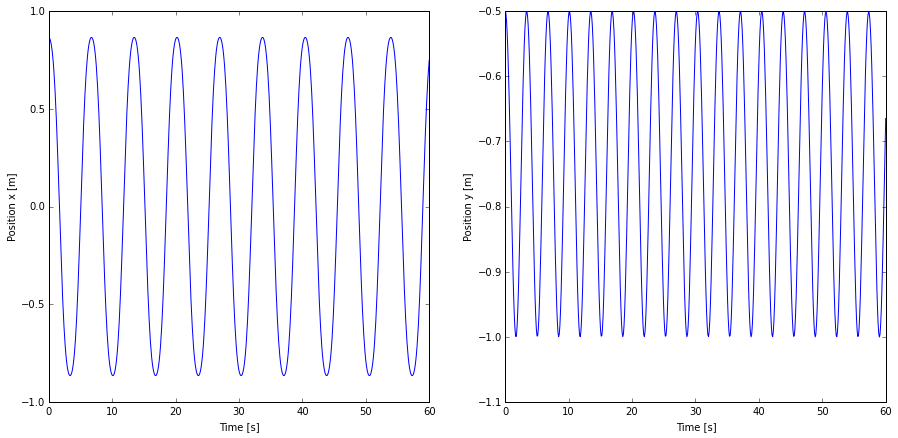

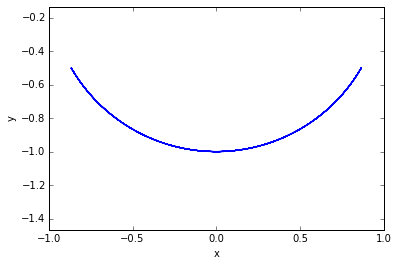

In [9]:
#plot of the oscilator
solver =  dae('ida', residual, 
             compute_initcond='yp0',
             first_step_size=1e-18,
             atol=1e-6,
             rtol=1e-6,
             algebraic_vars_idx=[4],
             old_api=False,
             max_steps=5000)
times = np.linspace(0,60,600)
solution = solver.solve(times, z0, zp0)
f, axs = plt.subplots(2,2,figsize=(15,7))
plt.subplot(1, 2, 1)
plt.plot(solution.values.t,[x[0] for x in solution.values.y])
plt.xlabel('Time [s]')
plt.ylabel('Position x [m]')
plt.subplot(1, 2, 2)
plt.plot(solution.values.t,[x[1] for x in solution.values.y])
plt.xlabel('Time [s]')
plt.ylabel('Position y [m]')
plt.show()
# plot in space
plt.axis('equal')
plt.plot([x[0] for x in solution.values.y],[x[1] for x in solution.values.y],)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Planar Pendulum Example: Stepwise running
When using the solve method, you solve over a period of time you decided before. In some problems you might want to solve and decide on the output when to stop. Then you use the step method. The same example as above using the step method can be solved as follows.

You define the dae object selecting the ida solver. You initialize the solver with the begin time and initial conditions using _init_step_. You compute solutions going forward with the _step_ method.

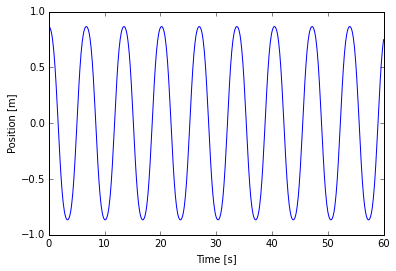

In [10]:
solver = dae('ida', residual, 
             compute_initcond='yp0',
             first_step_size=1e-18,
             atol=1e-6,
             rtol=1e-6,
             algebraic_vars_idx=[4],
             old_api=False)
time = 0.
solver.init_step(time, z0, zp0)
plott = []
plotx = []
while True:
    time += 0.1
    # fix roundoff error at end
    if time > 60: time = 60
    solution = solver.step(time)
    if solution.errors.t:
        print ('Error: ', solution.message, 'Error at time', solution.errors.t)
        break
    #we store output for plotting
    plott.append(solution.values.t)
    plotx.append(solution.values.y[0])
    if time >= 60:
        break
plt.plot(plott, plotx)
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.show()

The solver interpolates solutions to return the solution at the required output times:

In [11]:
print ('plott length:', len(plott), ', last computation times:', plott[-15:]);

plott length: 600 , last computation times: [58.60000000000056, 58.700000000000564, 58.800000000000566, 58.90000000000057, 59.00000000000057, 59.10000000000057, 59.20000000000057, 59.30000000000057, 59.400000000000574, 59.500000000000576, 59.60000000000058, 59.70000000000058, 59.80000000000058, 59.90000000000058, 60.0]


# Planar Pendulum  Example: Internal Solver Stepwise running
When using the *solve* method, you solve over a period of time you decided before. With the *step* method you solve by default towards a desired output time after which you can continue solving the problem. 

For full control, you can also compute problems using the solver internal steps. This is not advised, as the number of return steps can be very large, **slowing down** the computation enormously. If you want this nevertheless, you can achieve it with the *one_step_compute* option. Like this:

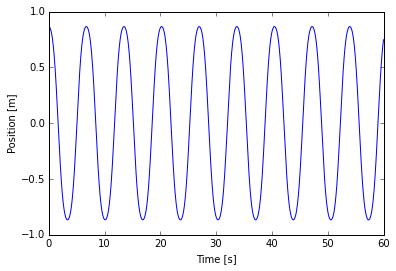

In [12]:
solver = dae('ida', residual, 
             compute_initcond='yp0',
             first_step_size=1e-18,
             atol=1e-6,
             rtol=1e-6,
             algebraic_vars_idx=[4],
             old_api=False, 
             one_step_compute=True)
time = 0.
solver.init_step(time, z0, zp0)
plott = []
plotx = []
while True:
    solution = solver.step(60)
    if solution.errors.t:
        print ('Error: ', solution.message, 'Error at time', solution.errors.t)
        break
    #we store output for plotting
    plott.append(solution.values.t)
    plotx.append(solution.values.y[0])
    if solution.values.t >= 60:
        #back up to 60
        solver.set_options(one_step_compute=False)
        solution = solver.step(60)
        plott[-1] = solution.values.t
        plotx[-1] = solution.values.y[0]
        break
plt.plot(plott,plotx)
plt.xlabel('Time [s]')
plt.ylabel('Position [m]')
plt.show()

By inspection of the returned times you can see how efficient the solver can solve this problem:

In [13]:
print ('plott length:', len(plott), ', last computation times:', plott[-15:]);

plott length: 1825 , last computation times: [59.67949916586178, 59.70385725557751, 59.72821534529324, 59.752573435008976, 59.77693152472471, 59.80128961444044, 59.825647704156175, 59.85000579387191, 59.87436388358764, 59.898721973303374, 59.92308006301911, 59.94743815273484, 59.97179624245057, 59.99371852319473, 60.0]


# Animation of the planar pendulum
No example of the pendulum is complete without an animation. Having fixed timestep output is ideal to create realistic animations of physical processes. We show at 10 frames per second the first 10 seconds next.
We start with loading functions to show animations

In [14]:
%run 'mpl_animation_html.ipynb'

import matplotlib
import matplotlib.animation as animation

In [15]:
solver = dae('ida', residual, 
             compute_initcond='yp0',
             first_step_size=1e-18,
             atol=1e-6,
             rtol=1e-6,
             algebraic_vars_idx=[4],
             old_api=False)
time = 0.
endtime = 10.
frames_per_second = 10.
timestep = 1/frames_per_second
solver.init_step(time, z0, zp0)
plott = []
plotx = []
ploty = []
while True:
    time += timestep
    # fix roundoff error at end
    if time > endtime: time = endtime
    solution = solver.step(time)
    if solution.errors.t:
        print ('Error: ', solution.message, 'Error at time', solution.errors.t)
        break
    #we store output for plotting
    plott.append(solution.values.t)
    plotx.append(solution.values.y[0])
    ploty.append(solution.values.y[1])
    if time >= endtime:
        break


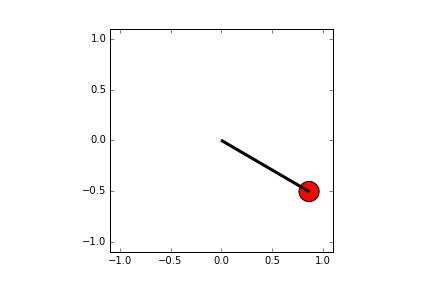
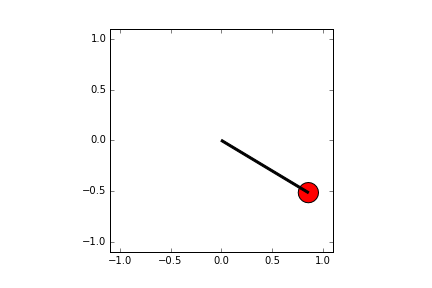
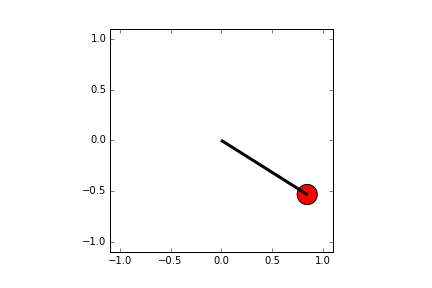
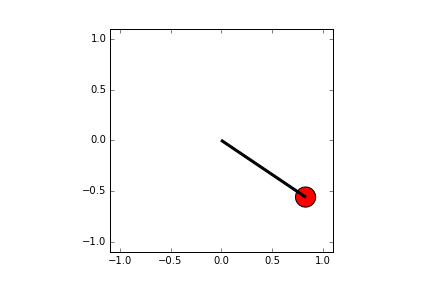
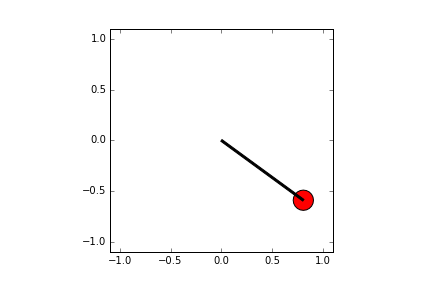
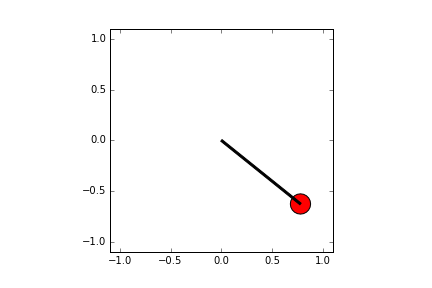
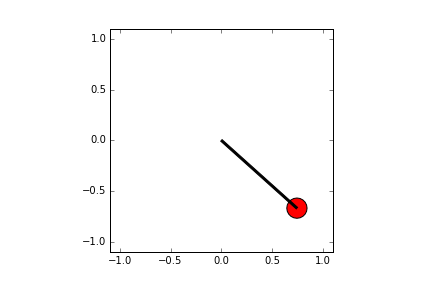
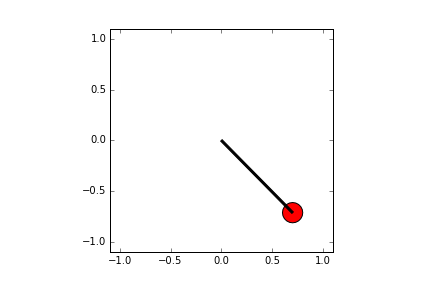
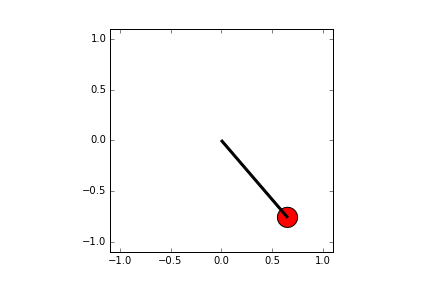
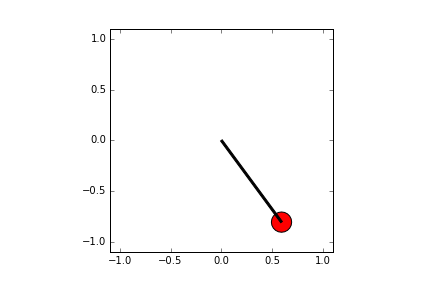
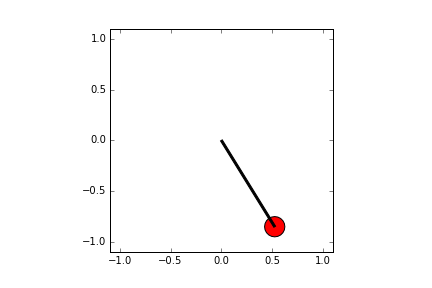
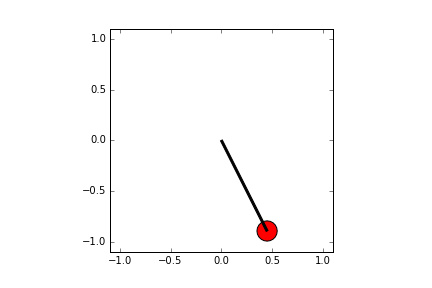
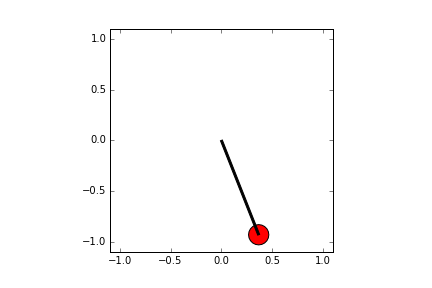
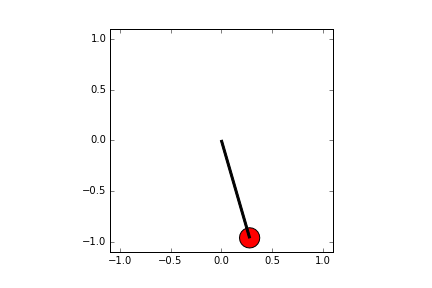
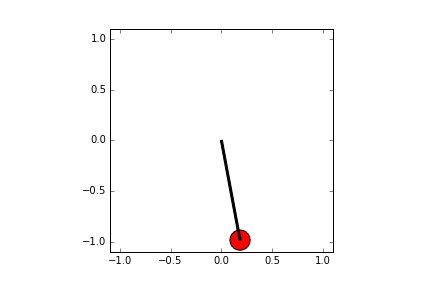
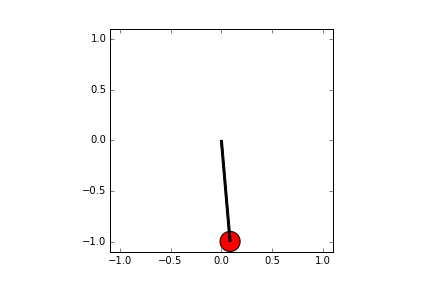
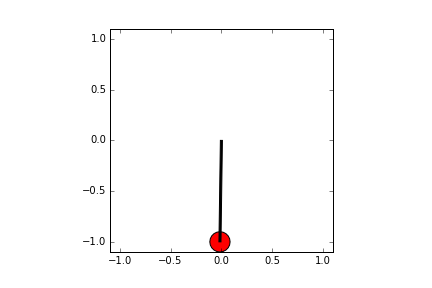
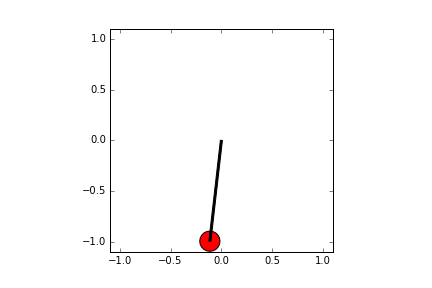
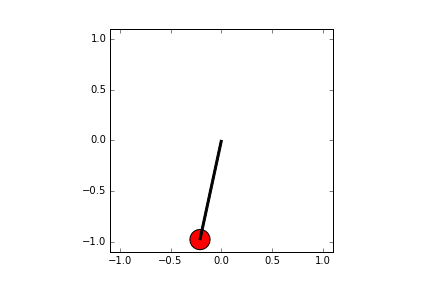
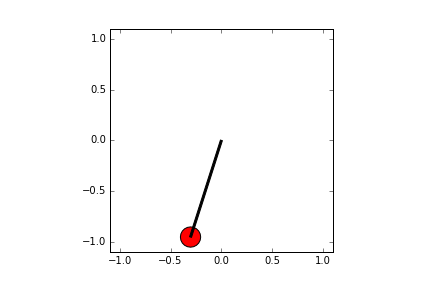
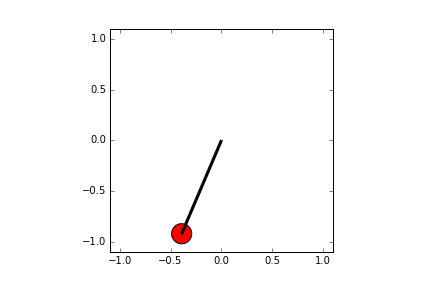
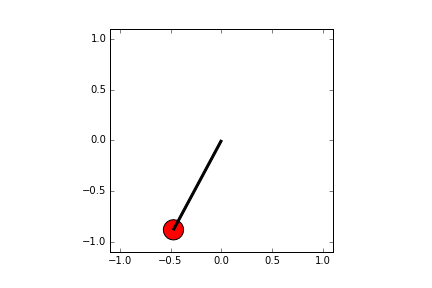
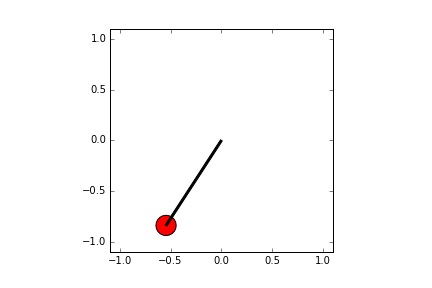
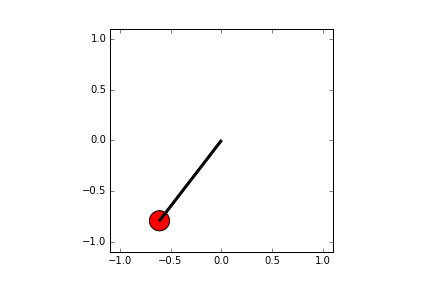
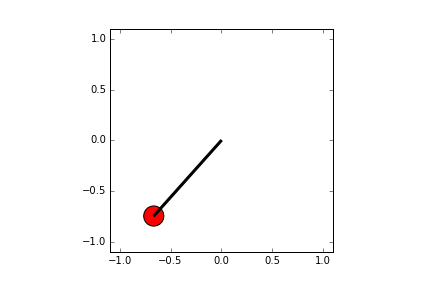
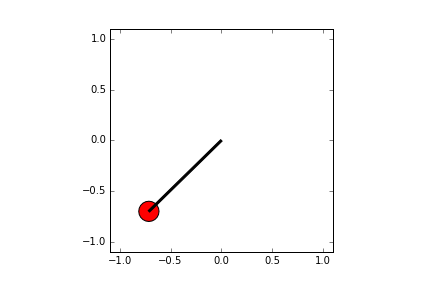
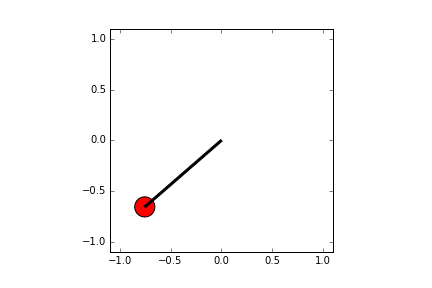
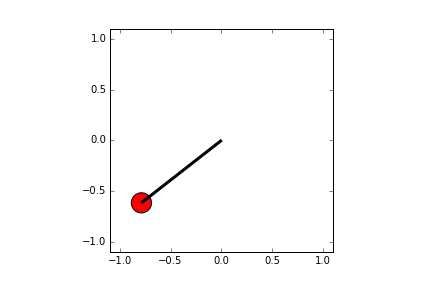
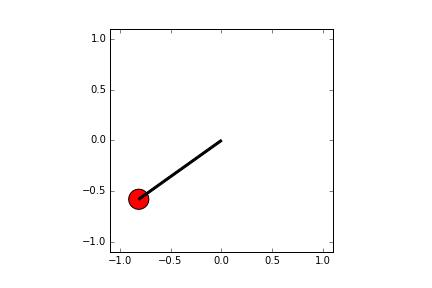
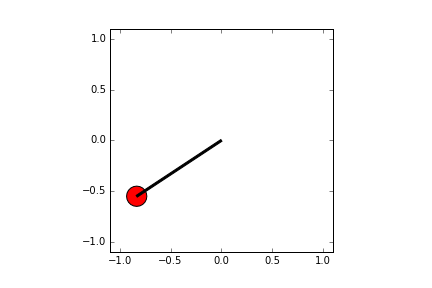
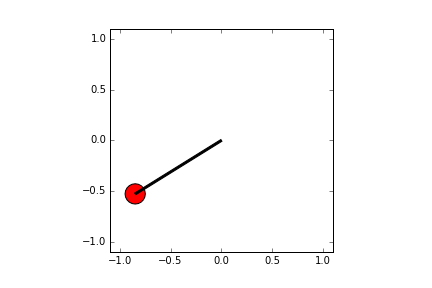
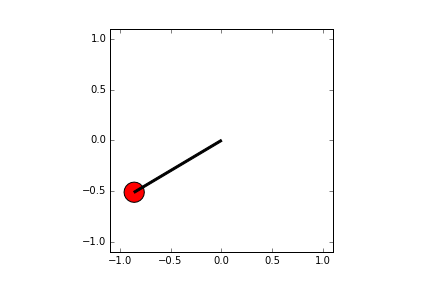
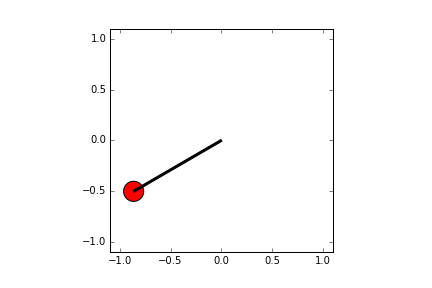
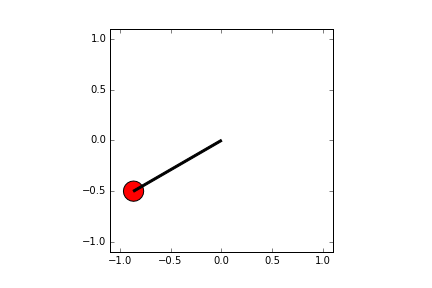
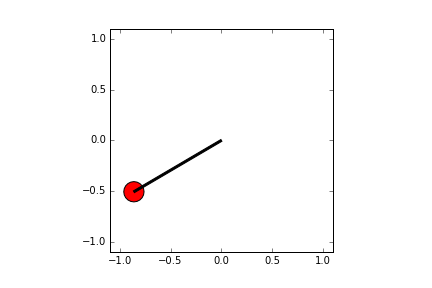
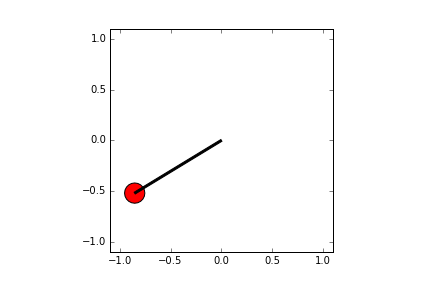
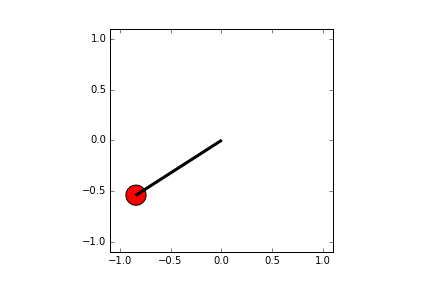
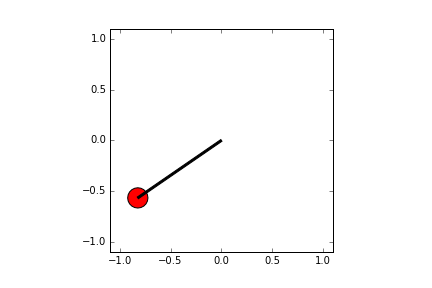
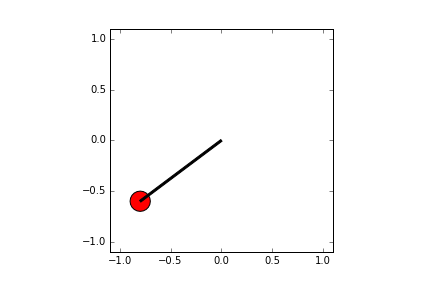
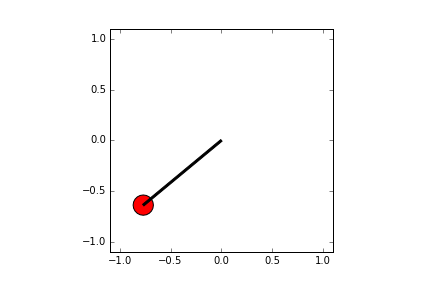
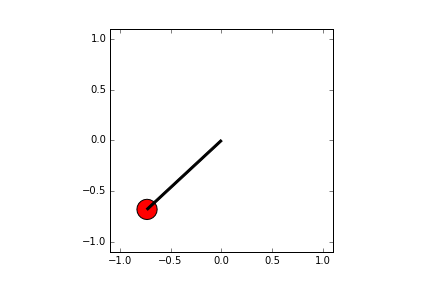
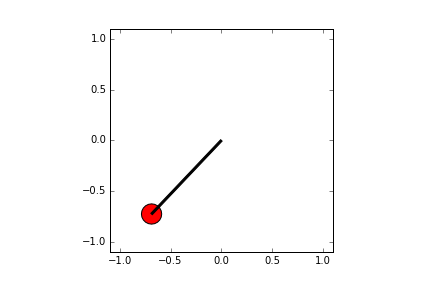
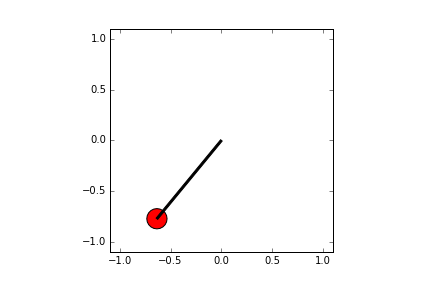
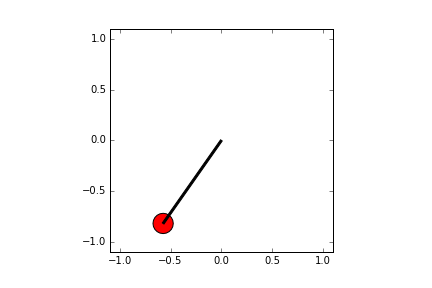
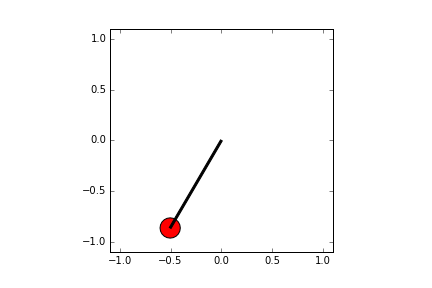
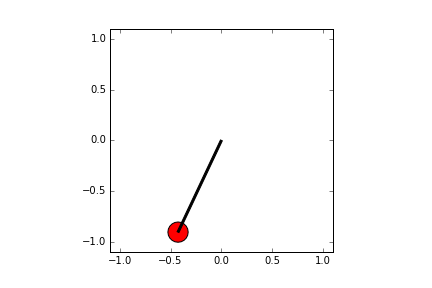
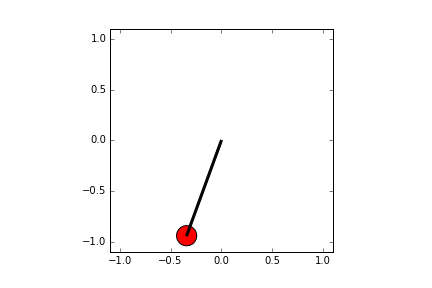
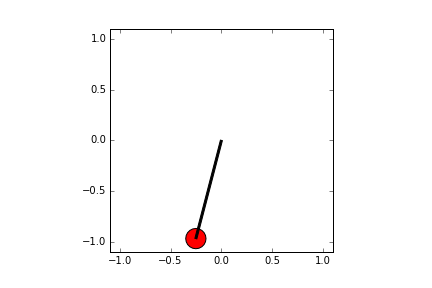
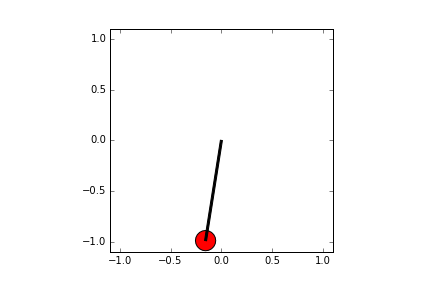
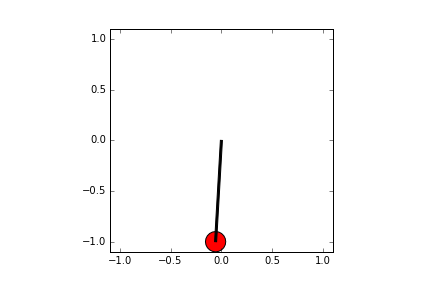
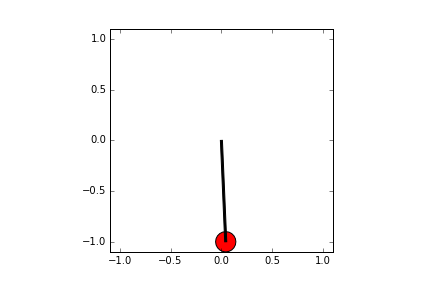
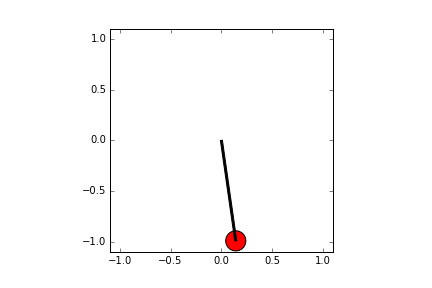
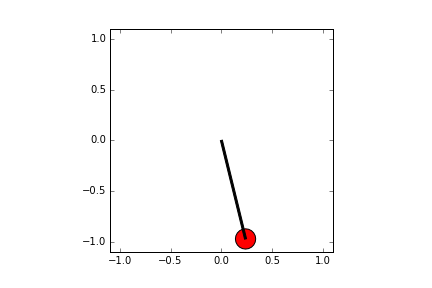
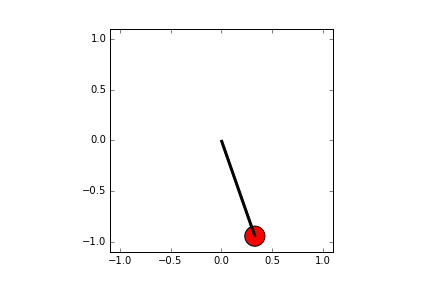
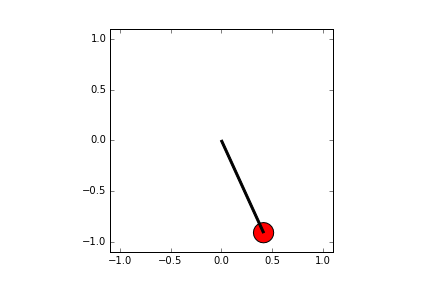
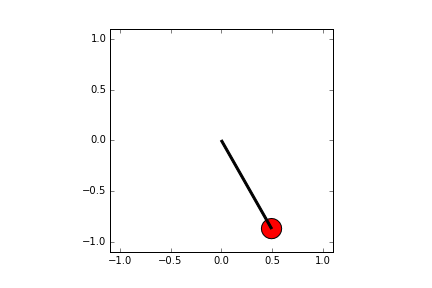
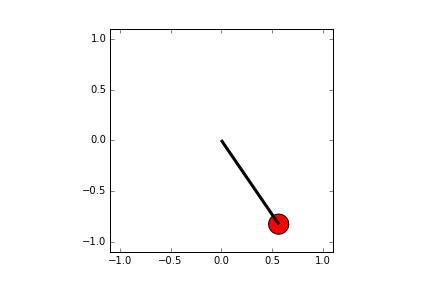
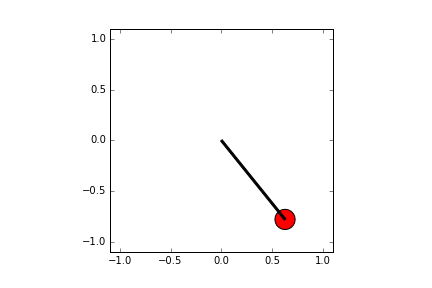
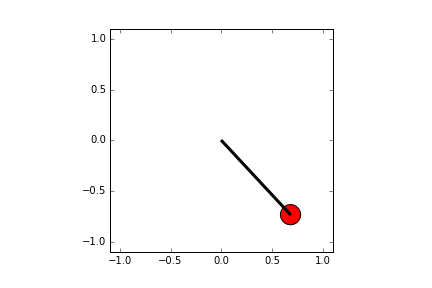
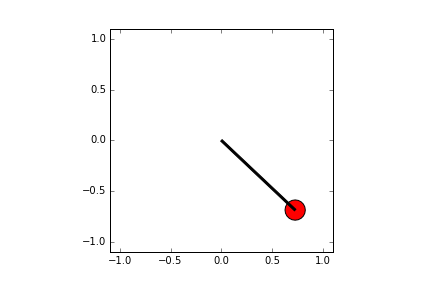
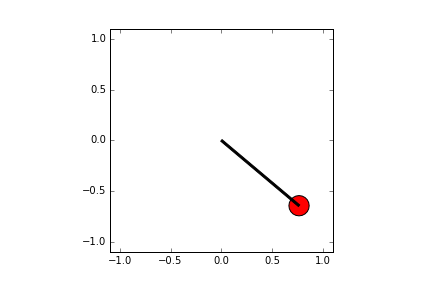
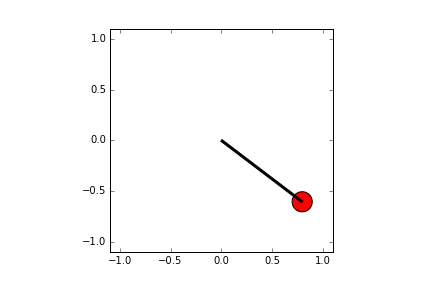
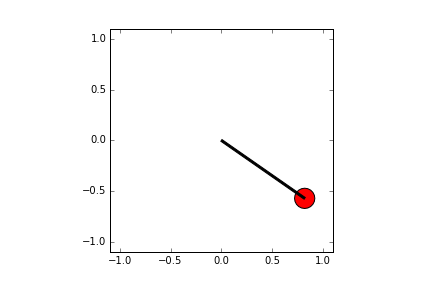
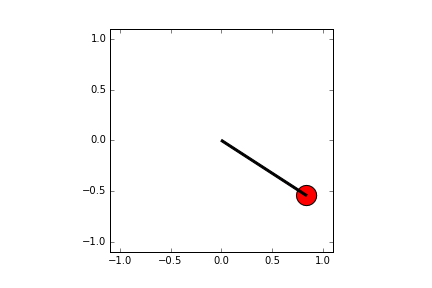
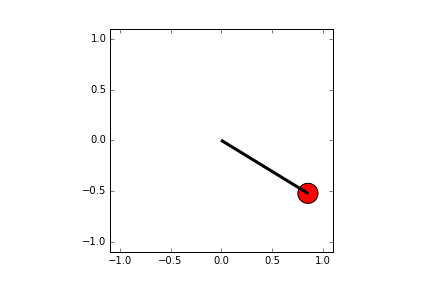
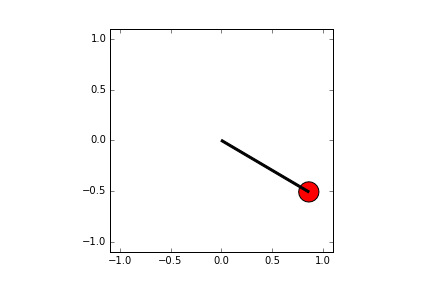
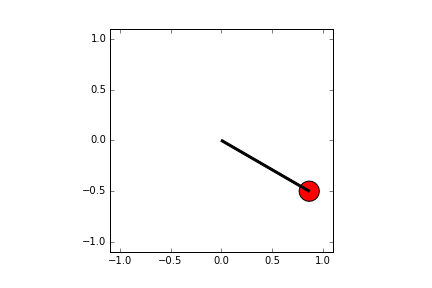
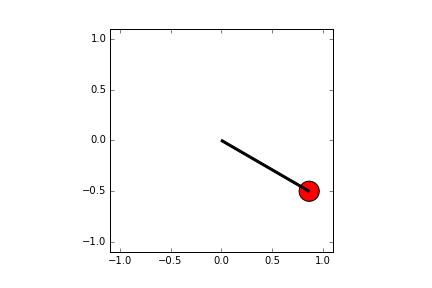
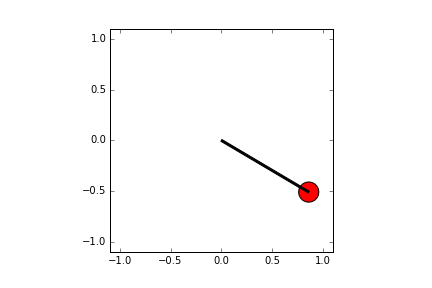
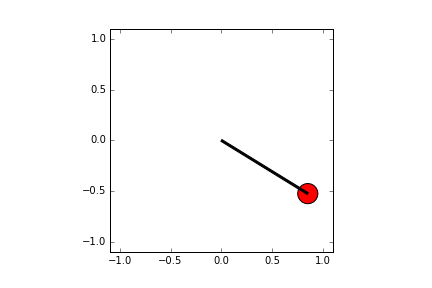
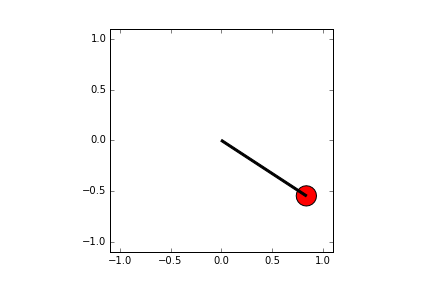
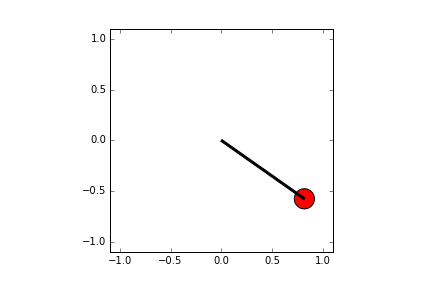
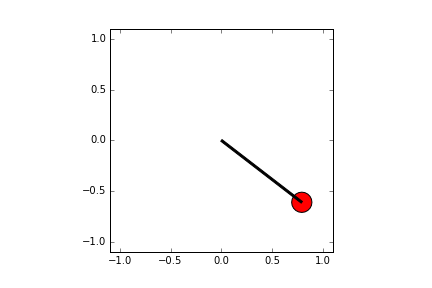
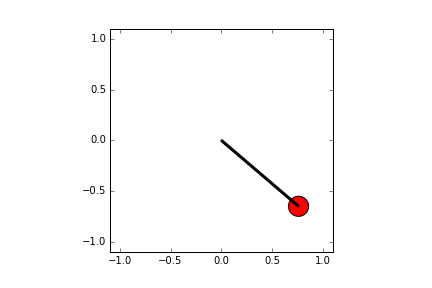
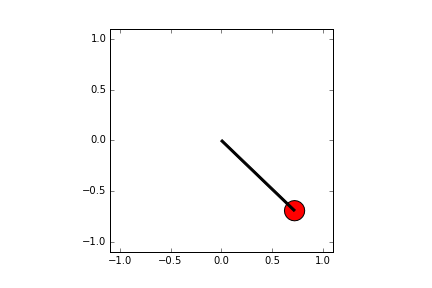
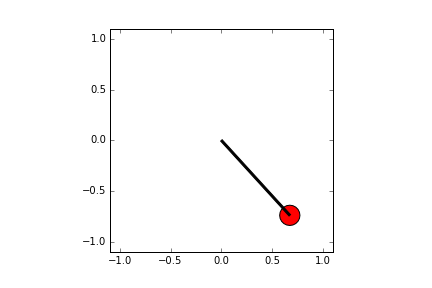
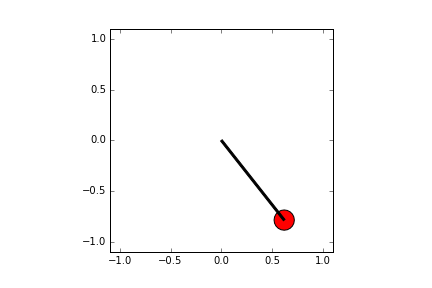
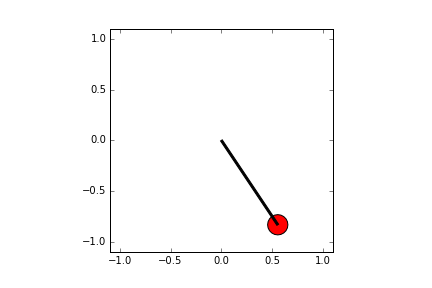
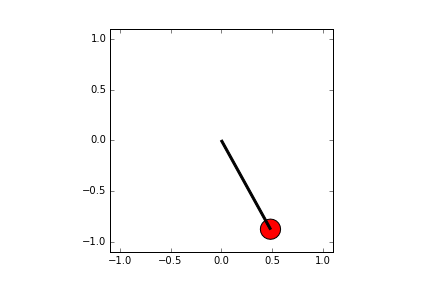
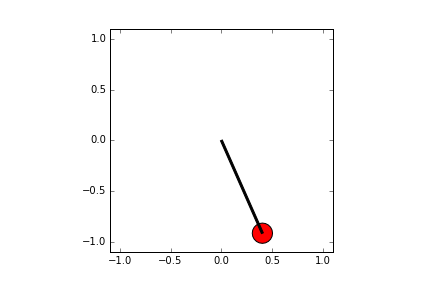
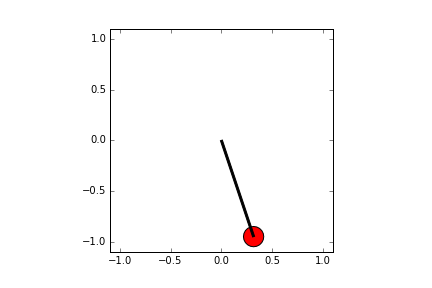
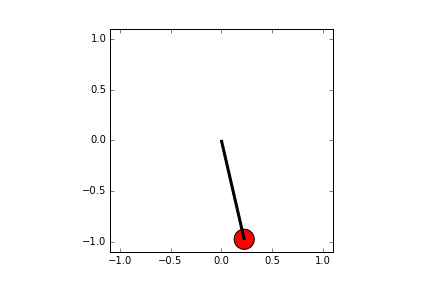
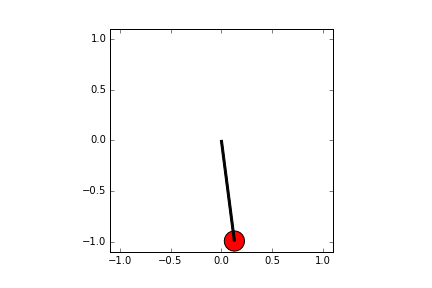
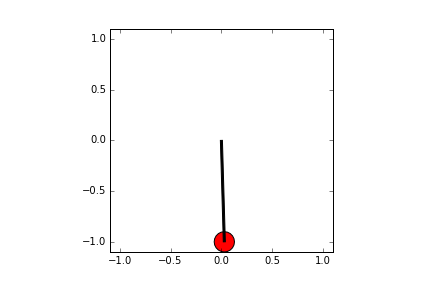
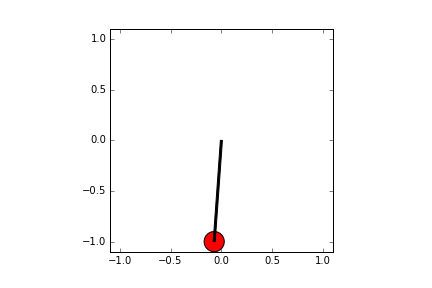
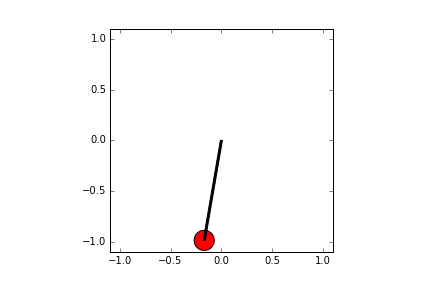
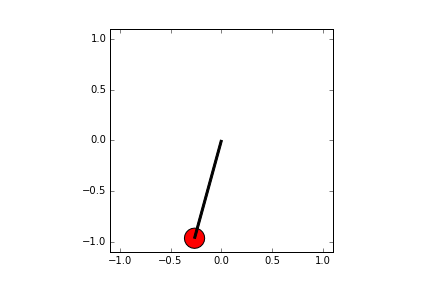
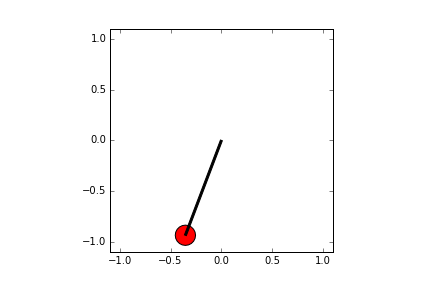
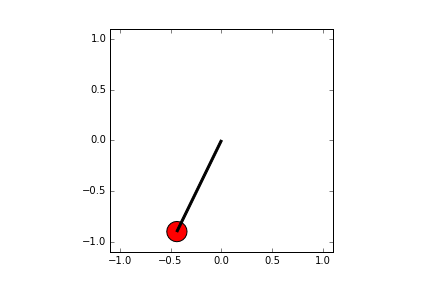
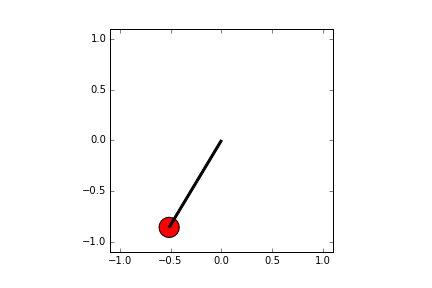
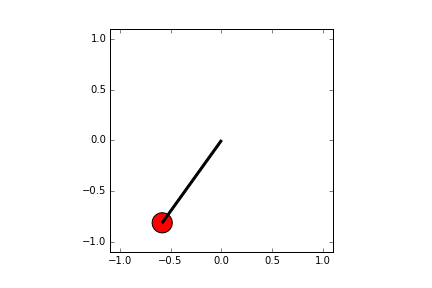
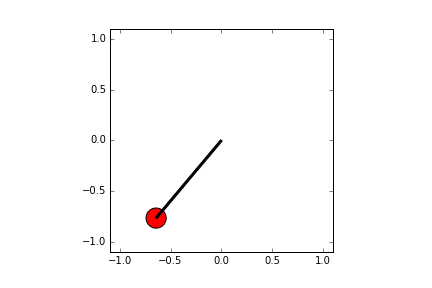
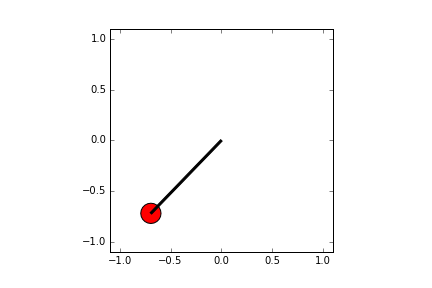
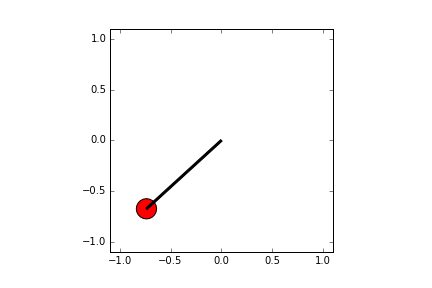
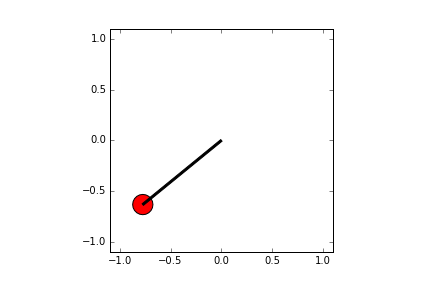
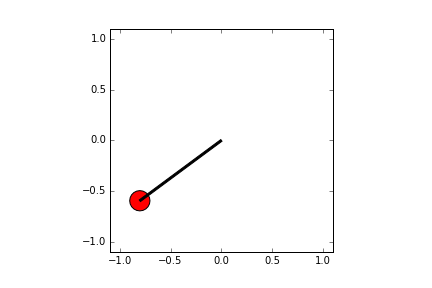
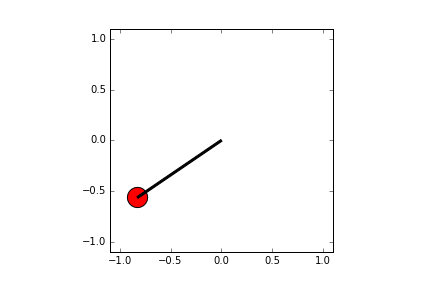
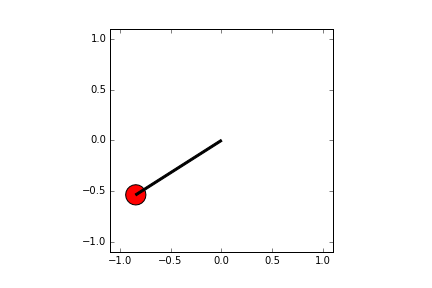
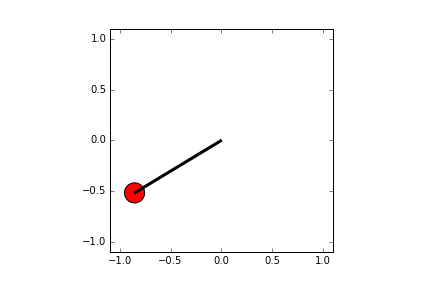
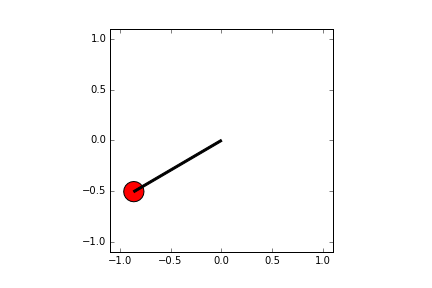
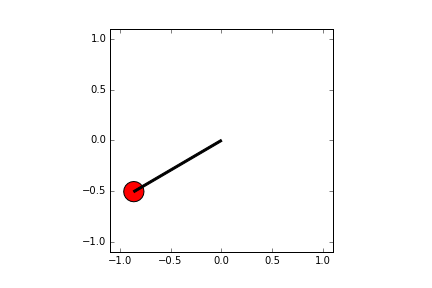

In [16]:
# First set up the figure, and the axis we want to animate
fig = plt.figure()
sizex = l*1.1
sizey = l*1.1
rad = l*0.1
ax = plt.axes(aspect='equal', xlim=(-sizex, sizex), ylim=(-sizey, sizey))

ims = []

def drawonesol(nr):
    artist1, = circle(ax, plotx[nr], ploty[nr], rad)
    artist2, = line(ax, 0, 0, plotx[nr], ploty[nr])
    return (artist2, artist1)

def create_animation(sizex, sizey):
    """
    The calculation step is 1e-2, so output every 5 solutions or 0.05, means
    a frame rate of 20 frames per second
    """
    for solnr in range(len(plott)):
        arts = drawonesol(solnr)
        ims.append(arts)

create_animation(sizex, sizey)
#one frame every 100 milliseconds
animation.ArtistAnimation(fig, ims, interval=1000/frames_per_second, blit=True)